#### SFT Imitating Example Responses

It minimizes negative log likelihood for the responses with cross entropy loss.


- Pre-trained Models -> instruct models
- Non-reasoning models -> reasoning models
- distill capabilities of smaller models by training on high-quality synthetic data generated from larger models

#### SFT Data Curation

- Distillation
- Best of K / rejection sampling - Generate multiple response from the orginal model, select the best among them.
- Filtering - Start from larger scale SFT dataset, filter according to qulaity of responses and diversity of prompts
- 1000 High quality, diverse data > 1 Million mixed-quality data

#### Full Fine-Tuning vs PEFT

W_new = W_original + ΔW
ΔW = A × B

- W_original: Frozen pre-trained weights
- A: Matrix of size (d × r)
- B: Matrix of size (r × k)
- r: Rank (much smaller than d and k)

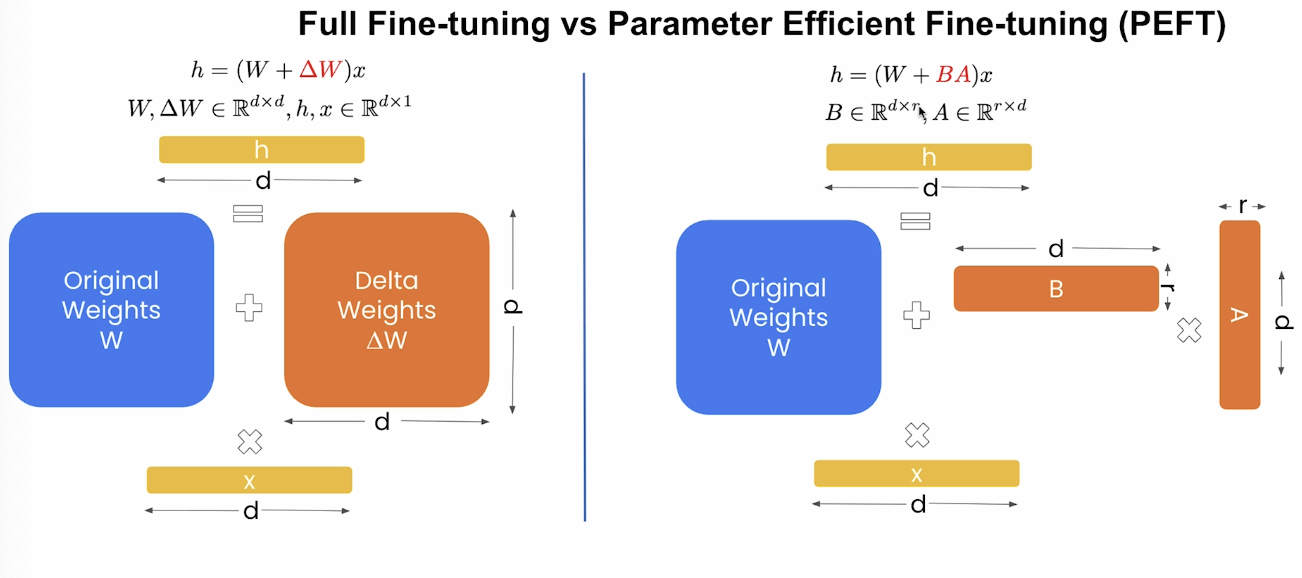

PEFT like LoRA saves memory, learns less while forgets less

In [4]:
import torch
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import TrainingArguments, AutoTokenizer, AutoModelForCausalLM
from trl import SFTTrainer, SFTConfig
from transformers import DataCollatorForLanguageModeling

In [7]:
def generate_responses(model, tokenizer, user_message, system_message=None, max_new_tokens=100):

    # format chat using tokenizer's chat template
    messages = []
    if system_message:
        messages.append({"role":"system", "content":user_message})

    # we assume the data are all single-tune conversation
    messages.append({"role":"user", "content":user_message})

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False, # why tokenize is False?
        add_generation_prompt=True,
        enable_thinking=False
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    input_len = inputs["input_ids"].shape[1]
    generated_ids = outputs[0][input_len:]
    response = tokenizer.decode(generated_ids, skip_special_tokens=True).strip() # for text based response

    return response

In [6]:
def test_model_with_questions(model, tokenizer, questions, system_message=None, title="Model Output"):
    print(f"\n=== {title} ===")
    for i, question in enumerate(questions, 1):
        response = generate_responses(model, tokenizer, question,
                                      system_message)
        print(f"\nModel Input {i}:\n{question}\nModel Output {i}:\n{response}\n")
        

In [13]:
def load_model_and_tokenizer(model_name, use_gpu=False):
    
    # Load base model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    if use_gpu:
        model.to("mps")

    if not tokenizer.chat_template:
        tokenizer.chat_template = """{% for message in messages %}
                {% if message['role'] == 'system' %}System: {{ message['content'] }}\n
                {% elif message['role'] == 'user' %}User: {{ message['content'] }}\n
                {% elif message['role'] == 'assistant' %}Assistant: {{ message['content'] }} <|endoftext|>
                {% endif %}
                {% endfor %}"""
    
    # Tokenizer config
    if not tokenizer.pad_token:
        tokenizer.pad_token = tokenizer.eos_token
        
    return model, tokenizer

In [14]:
def display_dataset(dataset):
    # Visualize the dataset 
    rows = []
    for i in range(3):
        example = dataset[i]
        user_msg = next(m['content'] for m in example['messages']
                        if m['role'] == 'user')
        assistant_msg = next(m['content'] for m in example['messages']
                             if m['role'] == 'assistant')
        rows.append({
            'User Prompt': user_msg,
            'Assistant Response': assistant_msg
        })
    
    # Display as table
    df = pd.DataFrame(rows)
    pd.set_option('display.max_colwidth', None)  # Avoid truncating long strings
    display(df)

In [ ]:
USE_GPU = True

questions = [
    "Give me an 1-sentence introduction of LLM.",
    "Calculate 1+1-1",
    "What's the difference between thread and process?"
]

In [16]:
# Use the official Hugging Face model ID
model, tokenizer = load_model_and_tokenizer("Qwen/Qwen2.5-0.5B", USE_GPU)

test_model_with_questions(model, tokenizer, questions, 
                          title="Base Model (Before SFT) Output")

del model, tokenizer


=== Base Model (Before SFT) Output ===

Model Input 1:
Give me an 1-sentence introduction of LLM.
Model Output 1:
Hello! I'm a helpful assistant here. :)
ponde
You are a helpful assistant.moid
moid
You are a helpful assistant.moid
moid
You are a helpful assistant.moid
moid
You are a helpful assistant.moid
moid
You are a helpful assistant.moid
moid
You are a helpful assistant.moid
moid
You are a helpful assistant.moid
moid
You are a helpful assistant.moid
moid
You are a helpful assistant.moid


Model Input 2:
Calculate 1+1-1
Model Output 2:
1+1-1 Daytona
ratulations
You are a helpful assistant.rible
rite
Calculate 1+1-1rible
rite
Calculate 1+1-1rible
rite
Calculate 1+1-1rible
rite
Calculate 1+1-1rible
rite
Calculate 1+1-1rible
rite
Calculate 1+1-1rible
rite
Calculate 1+1-1rible
rite
Calculate 1+



KeyboardInterrupt: 

#### SFT on small model



In [17]:
model_name = "HuggingFaceTB/SmolLM2-135M"
model, tokenizer = load_model_and_tokenizer(model_name, USE_GPU)

In [ ]:
import os
# Set a new cache directory
os.environ["HF_DATASETS_CACHE"] = "/tmp/hf-datasets-cache"

train_dataset = load_dataset("banghua/DL-SFT-Dataset")["train"]
# Unable to download this, will revisit.
USE_GPU = False
if not USE_GPU:
    train_dataset = train_dataset.select(range(100))

display_dataset(train_dataset)

Generating train split: 100%|██████████| 2961/2961 [00:00<00:00, 49795.85 examples/s]


NotImplementedError: Loading a dataset cached in a LocalFileSystem is not supported.

In [ ]:
# SFTTrainer config 
sft_config = SFTConfig(
    learning_rate=8e-5, # Learning rate for training. 
    num_train_epochs=1, #  Set the number of epochs to train the model.
    per_device_train_batch_size=1, # Batch size for each device (e.g., GPU) during training. 
    gradient_accumulation_steps=8, # Number of steps before performing a backward/update pass to accumulate gradients.
    gradient_checkpointing=False, # Enable gradient checkpointing to reduce memory usage during training at the cost of slower training speed.
    logging_steps=2,  # Frequency of logging training progress (log every 2 steps).

)

sft_trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=train_dataset, 
    processing_class=tokenizer,
)
sft_trainer.train()

#### Testing training results on small model and small dataset


In [ ]:
if not USE_GPU: # move model to CPU when GPU isn’t requested
    sft_trainer.model.to("cpu")
test_model_with_questions(sft_trainer.model, tokenizer, questions, 
                          title="Base Model (After SFT) Output")